# Project Energie Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format = 'retina'

print("Configuration terminée!")

Configuration terminée!


In [2]:
# URLs des données sur GitHub
BASE_URL = "https://raw.githubusercontent.com/pierrelux/mlbook/main/data/"

# Charger les données
print("Chargement des données depuis GitHub...")
train = pd.read_csv(BASE_URL + "energy_train.csv", parse_dates=['horodatage_local'])

# Pour l'évaluation locale: test avec la cible (energie_kwh)
test = pd.read_csv(BASE_URL + "energy_test_avec_cible.csv", parse_dates=['horodatage_local'])

# Pour Kaggle: test sans la cible (pour générer les prédictions)
test_kaggle = pd.read_csv(BASE_URL + "energy_test.csv", parse_dates=['horodatage_local'])

print(f"Ensemble d'entraînement: {len(train)} observations")
print(f"Ensemble de test: {len(test)} observations")
print(f"\nPériode d'entraînement: {train['horodatage_local'].min()} à {train['horodatage_local'].max()}")
print(f"Période de test: {test['horodatage_local'].min()} à {test['horodatage_local'].max()}")

Chargement des données depuis GitHub...
Ensemble d'entraînement: 8246 observations
Ensemble de test: 1754 observations

Période d'entraînement: 2022-01-01 05:00:00+00:00 à 2024-01-31 21:00:00+00:00
Période de test: 2024-02-01 01:00:00+00:00 à 2024-07-01 03:00:00+00:00


In [3]:
# One-hot encode 'poste' column
poste_dummies_train = pd.get_dummies(train['poste'], prefix='poste')
poste_dummies_test = pd.get_dummies(test['poste'], prefix='poste')
poste_dummies_kaggle = pd.get_dummies(test_kaggle['poste'], prefix='poste')

train = pd.concat([train, poste_dummies_train], axis=1)
test = pd.concat([test, poste_dummies_test], axis=1)
test_kaggle = pd.concat([test_kaggle, poste_dummies_kaggle], axis=1)

print("Added one-hot encoded 'poste' columns:")
print([col for col in train.columns if col.startswith('poste_')])

Added one-hot encoded 'poste' columns:
['poste_A', 'poste_B', 'poste_C']


In [4]:
# Aperçu des données
print("Colonnes disponibles:")
print(train.columns.tolist())
print(f"\nProportion événements de pointe (train): {train['evenement_pointe'].mean():.1%}")
train.head()

Colonnes disponibles:
['horodatage_local', 'poste', 'heure', 'jour', 'mois', 'jour_semaine', 'temperature_ext', 'humidite', 'vitesse_vent', 'neige', 'irradiance_solaire', 'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos', 'jour_semaine_sin', 'jour_semaine_cos', 'est_weekend', 'est_ferie', 'clients_connectes', 'tstats_intelligents_connectes', 'evenement_pointe', 'energie_kwh', 'poste_A', 'poste_B', 'poste_C']

Proportion événements de pointe (train): 0.9%


,horodatage_local,poste,heure,jour,mois,jour_semaine,temperature_ext,humidite,vitesse_vent,neige,...,jour_semaine_cos,est_weekend,est_ferie,clients_connectes,tstats_intelligents_connectes,evenement_pointe,energie_kwh,poste_A,poste_B,poste_C
0,2022-01-01 05:00:00+00:00,A,0,1,1,7,-1.2,92,0.5,0.0,...,1.0,1,1,17,118,0,60.931664,True,False,False
1,2022-01-01 06:00:00+00:00,A,1,1,1,7,-1.3,93,1.0,0.0,...,1.0,1,1,17,118,0,59.117008,True,False,False
2,2022-01-01 07:00:00+00:00,C,2,1,1,7,-1.2,93,1.0,0.0,...,1.0,1,1,35,220,0,142.911665,False,False,True
3,2022-01-01 08:00:00+00:00,A,3,1,1,7,-1.2,94,1.0,0.0,...,1.0,1,1,17,118,0,52.323657,True,False,False
4,2022-01-01 11:00:00+00:00,A,6,1,1,7,-1.0,97,1.5,0.0,...,1.0,1,1,17,118,0,78.351166,True,False,False


In [5]:
# Dataset time ranges
print("📅 DATASET TIME RANGES")
print("-" * 40)
print(f"Train: {train['horodatage_local'].min()} to {train['horodatage_local'].max()}")
print(f"Test:  {test['horodatage_local'].min()} to {test['horodatage_local'].max()}")
print(f"\nTrain samples: {len(train)}, Test samples: {len(test)}")

📅 DATASET TIME RANGES
----------------------------------------
Train: 2022-01-01 05:00:00+00:00 to 2024-01-31 21:00:00+00:00
Test:  2024-02-01 01:00:00+00:00 to 2024-07-01 03:00:00+00:00

Train samples: 8246, Test samples: 1754


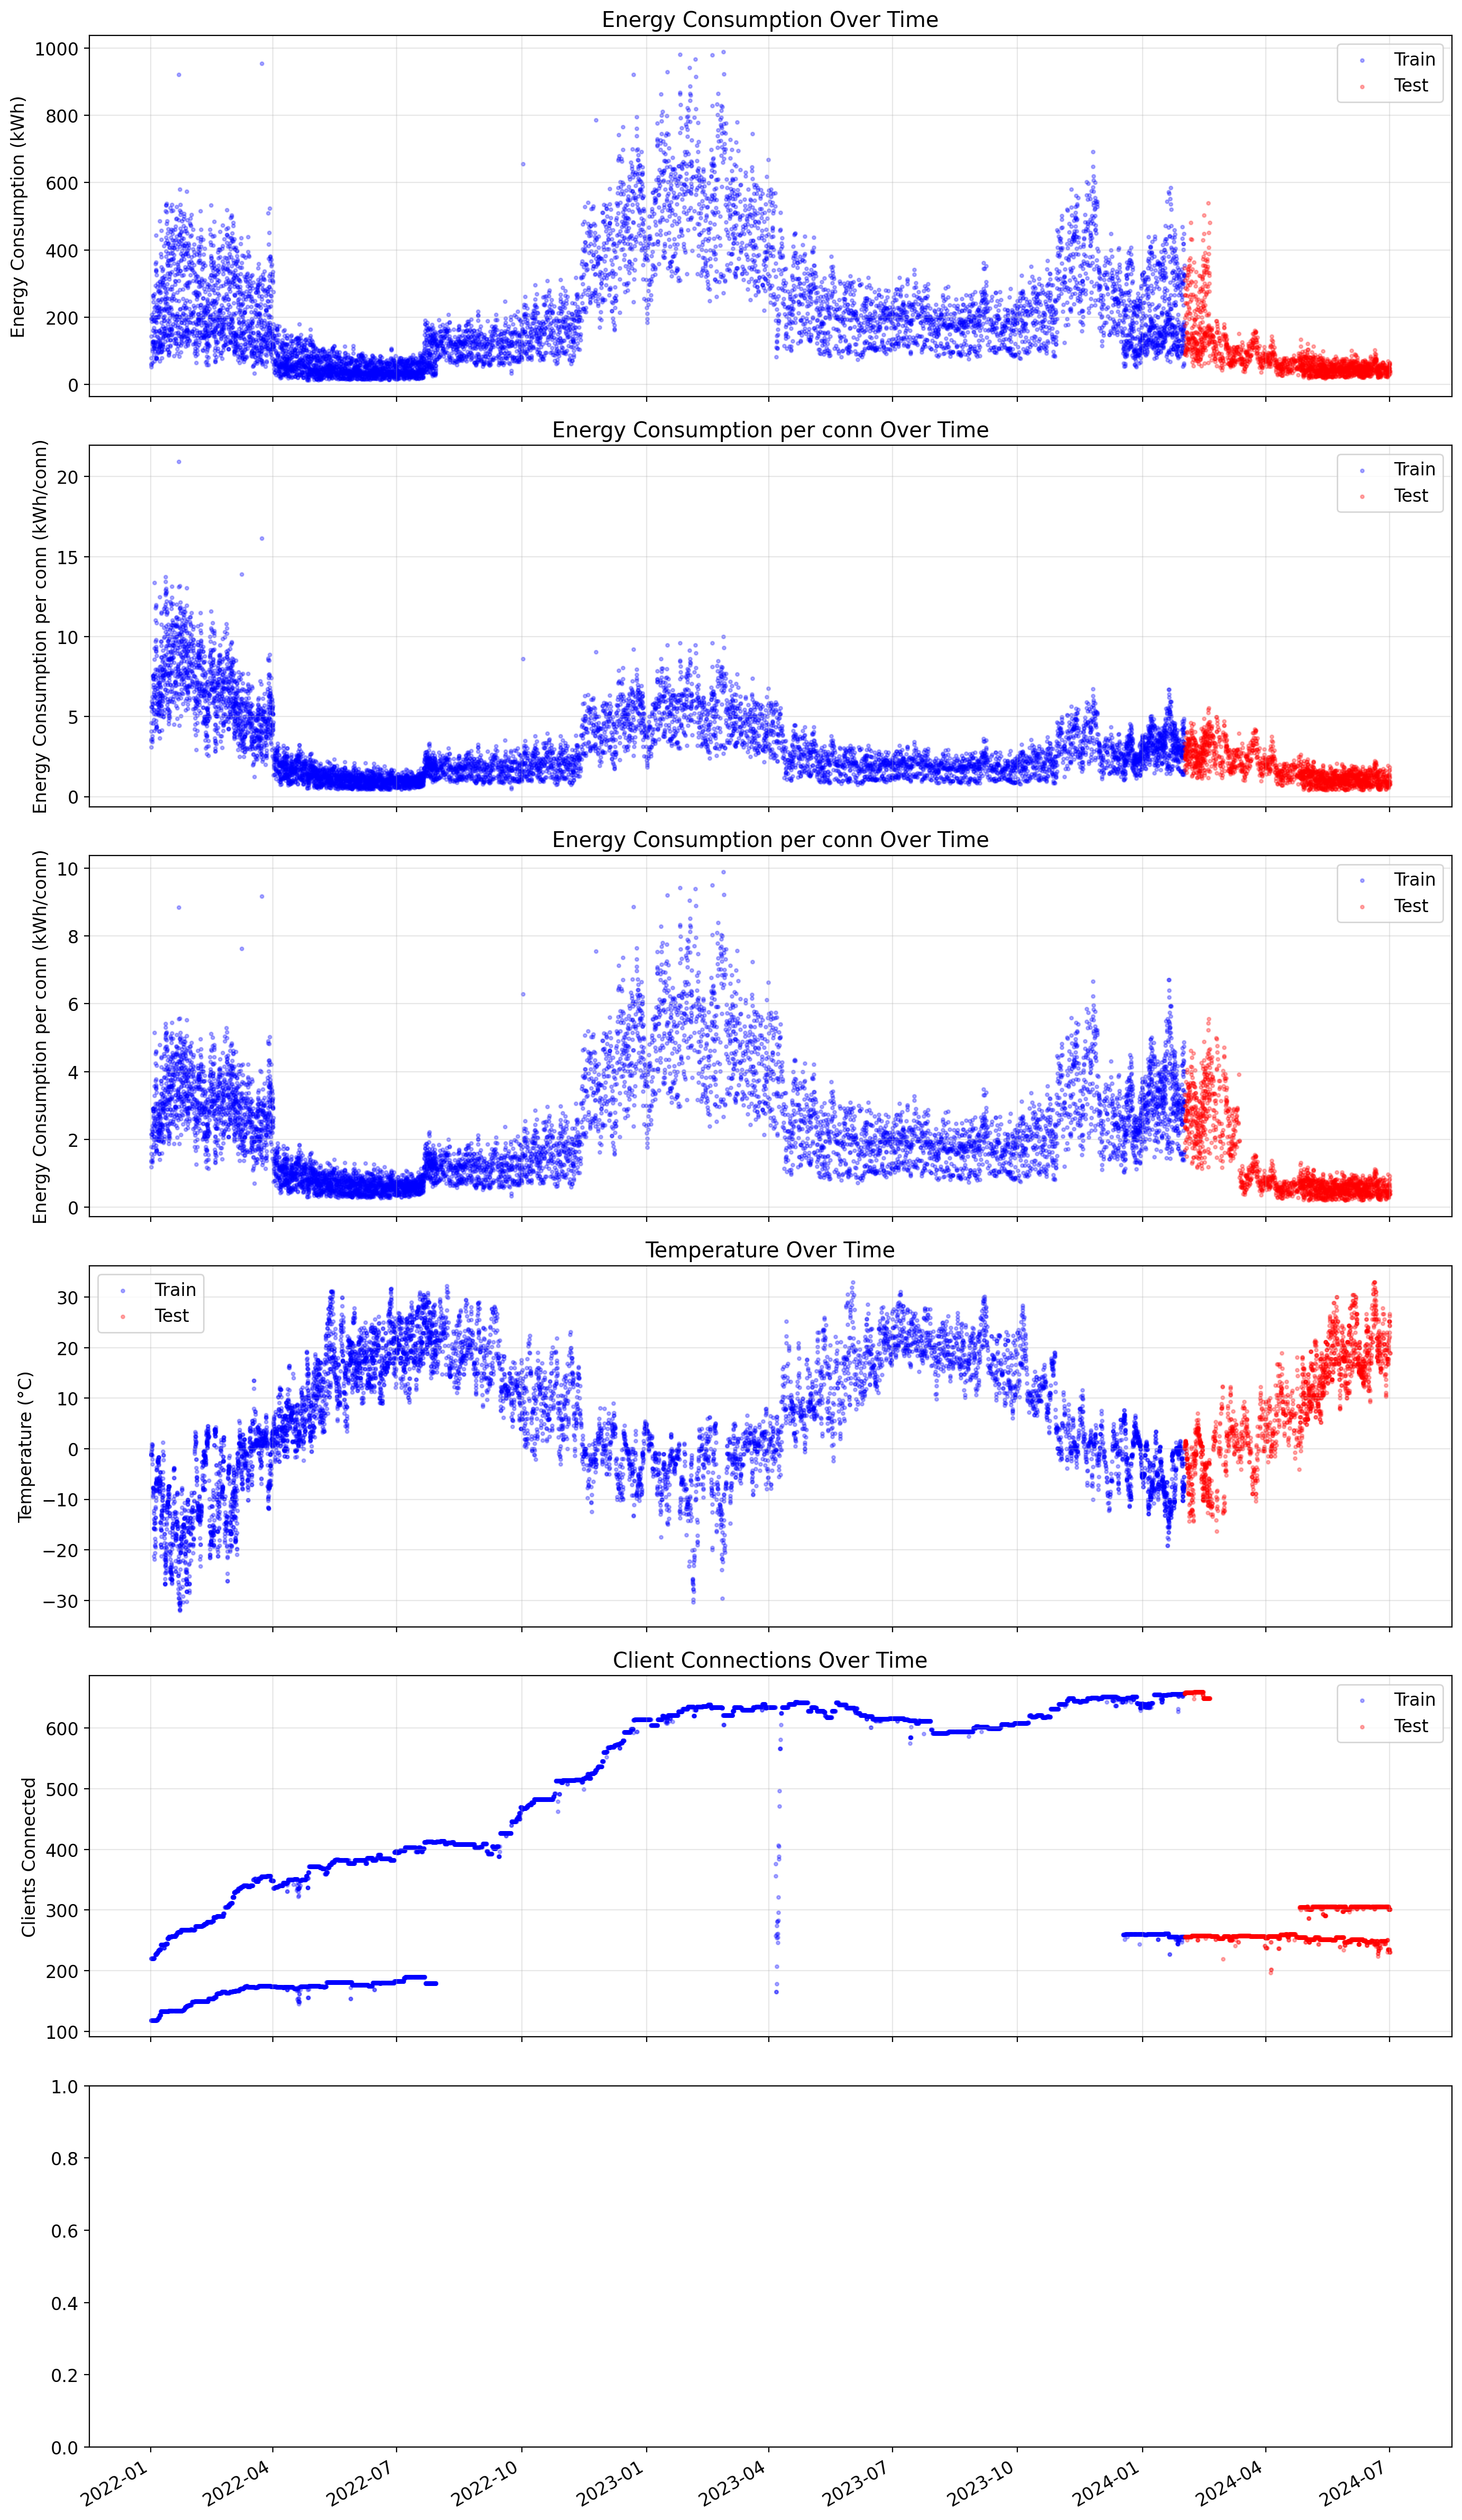

In [22]:
# Plot temperature and client connections against timestamp
plot_n = 6
fig, axes = plt.subplots(plot_n, 1, figsize=(14, plot_n * 4), sharex=True)

# Energy over time
ax = axes[0]
t_train = train[train['energie_kwh'] < 1000]
ax.scatter(t_train['horodatage_local'], t_train['energie_kwh'], 
                alpha=0.3, s=5, c='blue', label='Train')
ax.scatter(test['horodatage_local'], test['energie_kwh'], 
                alpha=0.3, s=5, c='red', label='Test')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Energy Consumption Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Energy per client connection over time
ax = axes[1]
t_train = train[train['energie_kwh'] < 1000]
ax.scatter(t_train['horodatage_local'], t_train['energie_kwh'] / t_train['clients_connectes'], 
                alpha=0.3, s=5, c='blue', label='Train')
ax.scatter(test['horodatage_local'], test['energie_kwh'] / test['clients_connectes'], 
                alpha=0.3, s=5, c='red', label='Test')
ax.set_ylabel('Energy Consumption per conn (kWh/conn)')
ax.set_title('Energy Consumption per conn Over Time')
ax.legend()
ax.grid(True, alpha=0.3)


# Energy per connection scaled over time
ax = axes[2]
t_train = train[train['energie_kwh'] < 1000]
conns = t_train['clients_connectes']
conns_scaled = conns * (conns.max() / conns.rolling(window=168).max().bfill())  # 168 hours = 7 days
ax.scatter(t_train['horodatage_local'], t_train['energie_kwh'] / conns_scaled, 
                alpha=0.3, s=5, c='blue', label='Train')
t_test = test[test['energie_kwh'] < 1000]
conns = t_test['clients_connectes']
conns_scaled = conns * (conns.max() / conns.rolling(window=168).max().bfill())  # 168 hours = 7 days
ax.scatter(t_test['horodatage_local'], t_test['energie_kwh'] / conns_scaled, 
                alpha=0.3, s=5, c='red', label='Test')
ax.set_ylabel('Energy Consumption per conn (kWh/conn)')
ax.set_title('Energy Consumption per conn Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Temperature over time
ax = axes[3]
ax.scatter(train['horodatage_local'], train['temperature_ext'], 
                alpha=0.3, s=5, c='blue', label='Train')
ax.scatter(test['horodatage_local'], test['temperature_ext'], 
                alpha=0.3, s=5, c='red', label='Test')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Temperature Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Client connections over time
ax = axes[4]
ax.scatter(train['horodatage_local'],  train['tstats_intelligents_connectes'], 
                alpha=0.3, s=5, c='blue', label='Train')
# ax.scatter(train['horodatage_local'], train['tstats_intelligents_connectes'], 
#                 alpha=0.3, s=5, c='green', label='Train')
ax.scatter(test['horodatage_local'], test['tstats_intelligents_connectes'], 
                alpha=0.3, s=5, c='red', label='Test')
ax.set_ylabel('Clients Connected')
ax.set_xlabel('Date')
ax.set_title('Client Connections Over Time')
ax.legend()
ax.grid(True, alpha=0.3)



# Format x-axis with dates
fig.autofmt_xdate()
plt.tight_layout()

SVD ANALYSIS SUMMARY

Number of features: 15
Number of samples: 8246

Singular values: [175.96 144.86 118.91  99.64  94.72  91.07  90.76  81.52  75.52  62.61
  55.07  45.67  27.9    2.46   0.  ]

Explained variance ratio: [25.03 16.97 11.43  8.03  7.25  6.71  6.66  5.37  4.61  3.17  2.45  1.69
  0.63  0.    0.  ]%
Cumulative variance: [ 25.03  42.    53.43  61.46  68.71  75.42  82.07  87.45  92.06  95.23
  97.68  99.37 100.   100.   100.  ]%

Components needed for 90% variance: 9

Top 3 features per component:
  PC1: [('clients_connectes', np.float64(0.491)), ('tstats_intelligents_connectes', np.float64(0.484)), ('poste_C', np.float64(0.476))]
  PC2: [('irradiance_solaire', np.float64(0.495)), ('temperature_ext', np.float64(0.483)), ('mois_cos', np.float64(-0.434))]
  PC3: [('vitesse_vent', np.float64(0.447)), ('heure_cos', np.float64(-0.396)), ('mois_cos', np.float64(0.371))]


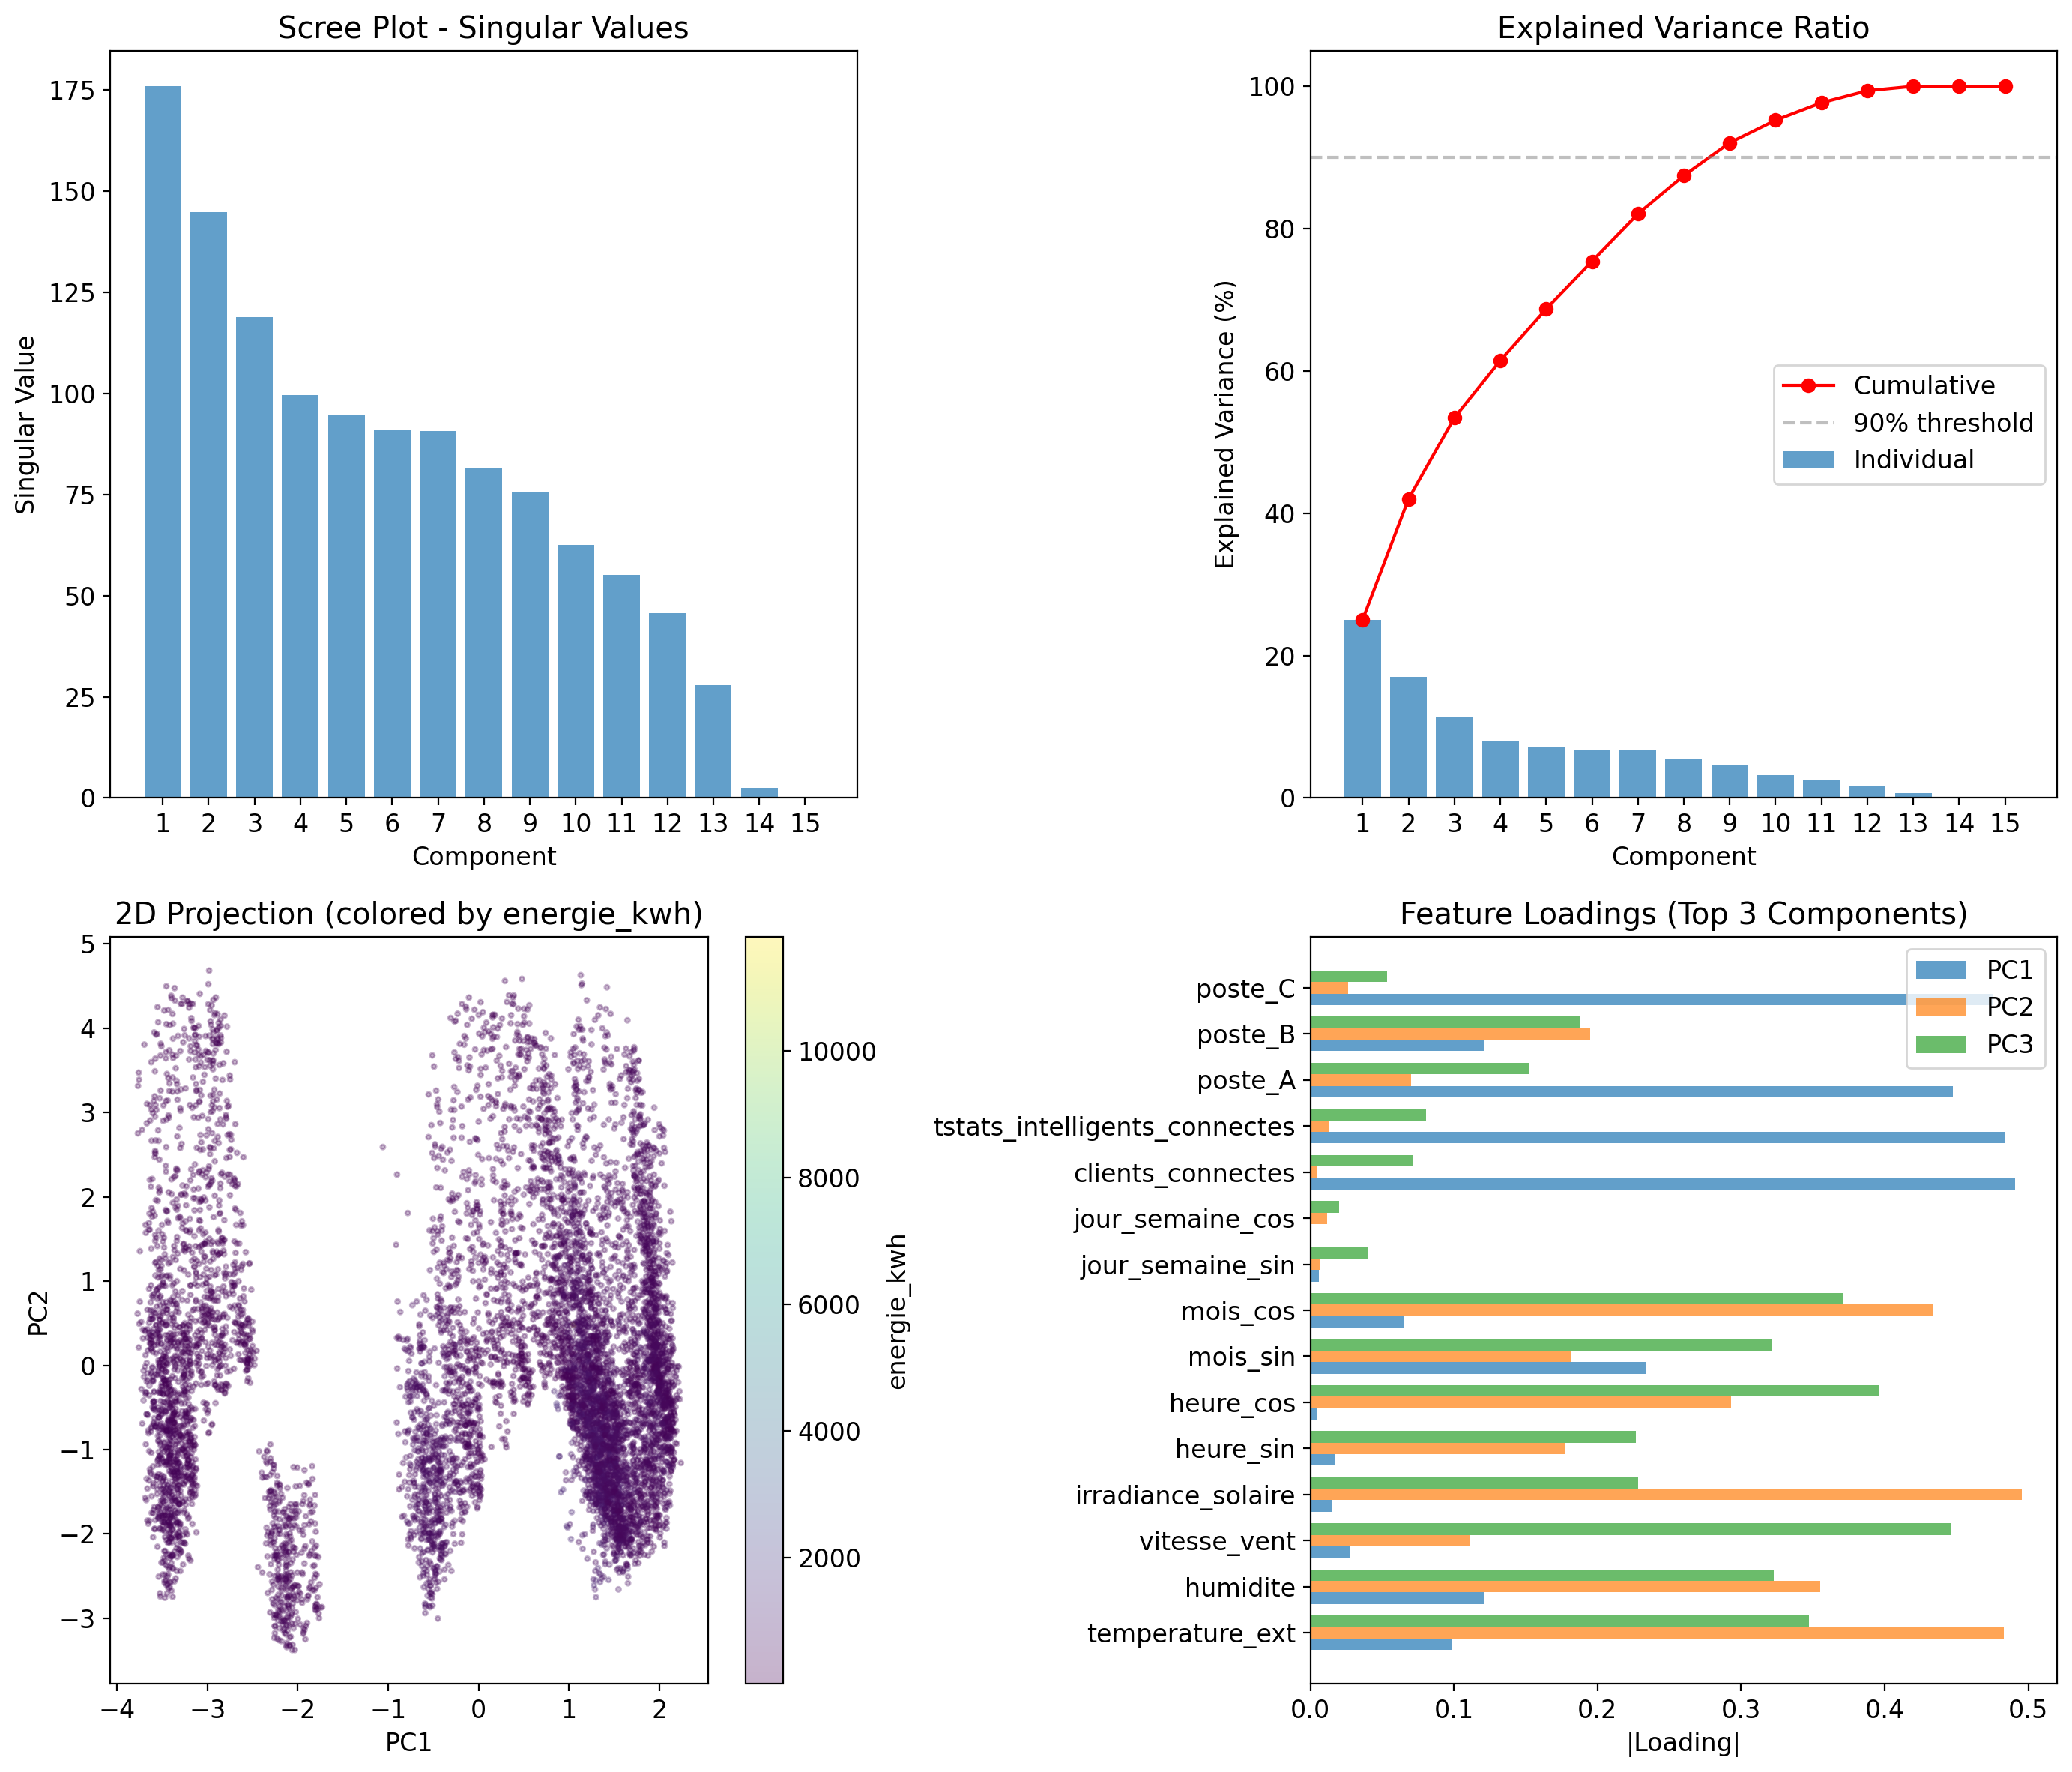

In [7]:
# SVD Analysis
from sklearn.preprocessing import StandardScaler

# Select numeric features for SVD (exclude target and non-numeric)
svd_features = [
    'temperature_ext', 'humidite', 'vitesse_vent', 'irradiance_solaire',
    'heure_sin', 'heure_cos', 'mois_sin', 'mois_cos',
    'jour_semaine_sin', 'jour_semaine_cos',
    'clients_connectes', 'tstats_intelligents_connectes',
    'poste_A', 'poste_B', 'poste_C'
]

# Prepare data (poste columns already one-hot encoded in earlier cell)
X_svd = train[svd_features].values
y_svd = train['energie_kwh'].values

# Scale features (important for SVD)
scaler_svd = StandardScaler()
X_svd_scaled = scaler_svd.fit_transform(X_svd)

# Apply SVD
U, S, Vt = np.linalg.svd(X_svd_scaled, full_matrices=False)

# Calculate explained variance ratio
explained_variance = (S ** 2) / (len(X_svd_scaled) - 1)
total_variance = explained_variance.sum()
explained_variance_ratio = explained_variance / total_variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scree plot - Singular values
ax = axes[0, 0]
ax.bar(range(1, len(S) + 1), S, alpha=0.7, label='Singular Values')
ax.set_xlabel('Component')
ax.set_ylabel('Singular Value')
ax.set_title('Scree Plot - Singular Values')
ax.set_xticks(range(1, len(S) + 1))

# 2. Explained variance ratio
ax = axes[0, 1]
ax.bar(range(1, len(S) + 1), explained_variance_ratio * 100, alpha=0.7, label='Individual')
ax.plot(range(1, len(S) + 1), cumulative_variance_ratio * 100, 'ro-', label='Cumulative')
ax.axhline(y=90, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
ax.set_xlabel('Component')
ax.set_ylabel('Explained Variance (%)')
ax.set_title('Explained Variance Ratio')
ax.set_xticks(range(1, len(S) + 1))
ax.legend()

# 3. 2D projection (first 2 principal components)
ax = axes[1, 0]
# Project data onto first 2 components
X_projected = U[:, :2] * S[:2]
scatter = ax.scatter(X_projected[:, 0], X_projected[:, 1], 
                     c=y_svd, cmap='viridis', alpha=0.3, s=5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('2D Projection (colored by energie_kwh)')
plt.colorbar(scatter, ax=ax, label='energie_kwh')

# 4. Feature loadings for top 3 components
ax = axes[1, 1]
n_components = 3
loadings = Vt[:n_components, :].T  # Features x Components
x_pos = np.arange(len(svd_features))
width = 0.25
for i in range(n_components):
    ax.barh(x_pos + i * width, np.abs(loadings[:, i]), width, label=f'PC{i+1}', alpha=0.7)
ax.set_yticks(x_pos + width)
ax.set_yticklabels(svd_features)
ax.set_xlabel('|Loading|')
ax.set_title('Feature Loadings (Top 3 Components)')
ax.legend()

plt.tight_layout()

# Print summary
print("=" * 60)
print("SVD ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nNumber of features: {len(svd_features)}")
print(f"Number of samples: {len(X_svd_scaled)}")
print(f"\nSingular values: {S.round(2)}")
print(f"\nExplained variance ratio: {(explained_variance_ratio * 100).round(2)}%")
print(f"Cumulative variance: {(cumulative_variance_ratio * 100).round(2)}%")

# Components needed for 90% variance
n_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1
print(f"\nComponents needed for 90% variance: {n_90}")

# Top features for each component
print("\nTop 3 features per component:")
for i in range(min(3, len(S))):
    top_idx = np.argsort(np.abs(Vt[i, :]))[::-1][:3]
    top_features = [(svd_features[j], Vt[i, j].round(3)) for j in top_idx]
    print(f"  PC{i+1}: {top_features}")

POSTE CATEGORICAL FEATURE ANALYSIS

📊 VALUE COUNTS
----------------------------------------
Train set:
poste
C    6129
A    1751
B     366
Name: count, dtype: int64

Test set:
poste
B    1126
A     474
C     154
Name: count, dtype: int64

⚡ ENERGY STATISTICS BY POSTE
----------------------------------------
       Count    Mean     Std    Min       Max  Median
poste                                                
A       1751   82.73   62.71  13.01    361.60   52.66
B        366  129.81   37.00  52.33    254.86  125.99
C       6129  259.10  228.98  27.58  11804.20  216.20

📅 POSTE × TIME CROSS-TABULATION
----------------------------------------

Poste distribution by hour (peak hours 17-20):
poste     A    B     C
heure                 
17     24.4  3.8  71.8
18     17.9  5.9  76.3
19     20.5  4.3  75.2
20     19.5  4.1  76.5

Poste distribution weekend vs weekday:
poste           A    B     C
est_weekend                 
0            21.3  4.4  74.2
1            21.0  4.5  74.5


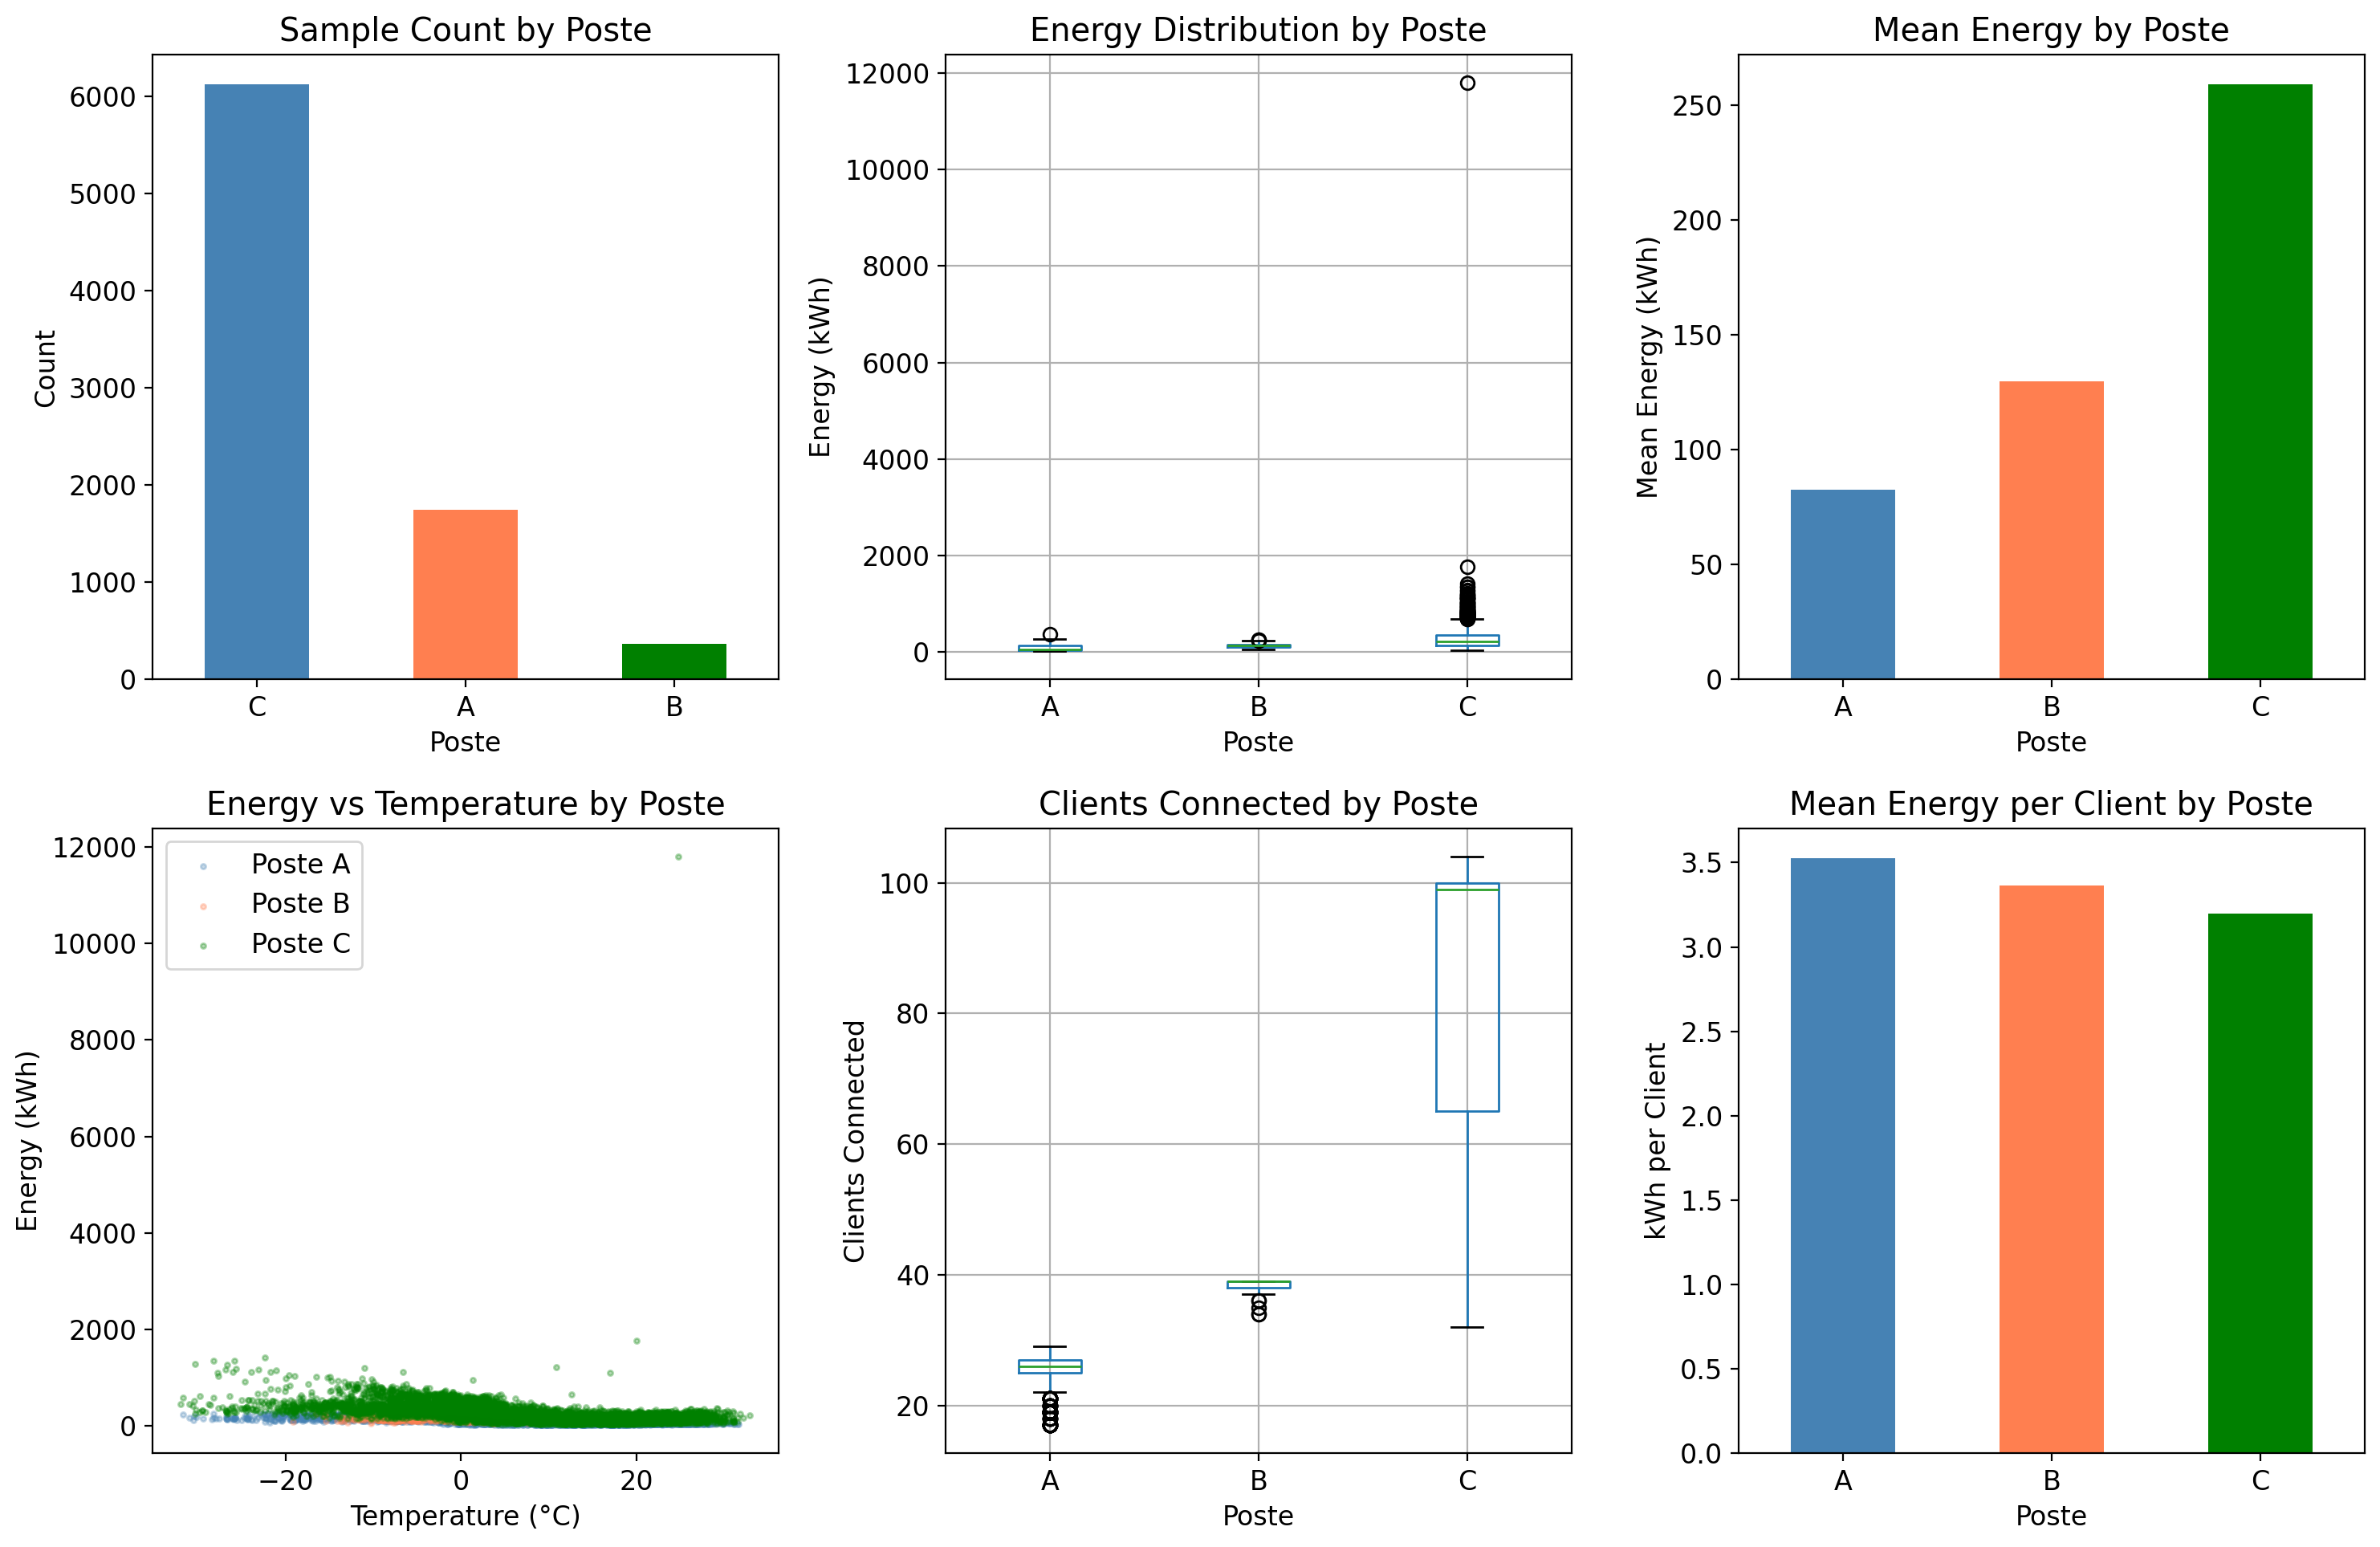

In [8]:
# get stats on 'poste' categorical feature
print("=" * 60)
print("POSTE CATEGORICAL FEATURE ANALYSIS")
print("=" * 60)

# 1. Value counts
print("\n📊 VALUE COUNTS")
print("-" * 40)
print("Train set:")
print(train['poste'].value_counts())
print(f"\nTest set:")
print(test['poste'].value_counts())

# 2. Energy statistics by poste
print("\n⚡ ENERGY STATISTICS BY POSTE")
print("-" * 40)
poste_stats = train.groupby('poste')['energie_kwh'].agg(['count', 'mean', 'std', 'min', 'max', 'median'])
poste_stats.columns = ['Count', 'Mean', 'Std', 'Min', 'Max', 'Median']
print(poste_stats.round(2))

# 3. Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 3a. Value counts bar plot
ax = axes[0, 0]
train['poste'].value_counts().plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'green'])
ax.set_title('Sample Count by Poste')
ax.set_xlabel('Poste')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)

# 3b. Energy distribution by poste (boxplot)
ax = axes[0, 1]
train.boxplot(column='energie_kwh', by='poste', ax=ax)
ax.set_title('Energy Distribution by Poste')
ax.set_xlabel('Poste')
ax.set_ylabel('Energy (kWh)')
plt.suptitle('')  # Remove automatic title

# 3c. Mean energy by poste
ax = axes[0, 2]
poste_means = train.groupby('poste')['energie_kwh'].mean()
poste_means.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'green'])
ax.set_title('Mean Energy by Poste')
ax.set_xlabel('Poste')
ax.set_ylabel('Mean Energy (kWh)')
ax.tick_params(axis='x', rotation=0)

# 3d. Energy vs Temperature by poste
ax = axes[1, 0]
colors = {'A': 'steelblue', 'B': 'coral', 'C': 'green'}
for poste in ['A', 'B', 'C']:
    data = train[train['poste'] == poste]
    ax.scatter(data['temperature_ext'], data['energie_kwh'], 
               alpha=0.3, s=5, c=colors[poste], label=f'Poste {poste}')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Energy (kWh)')
ax.set_title('Energy vs Temperature by Poste')
ax.legend()

# 3e. Clients connected by poste
ax = axes[1, 1]
train.boxplot(column='clients_connectes', by='poste', ax=ax)
ax.set_title('Clients Connected by Poste')
ax.set_xlabel('Poste')
ax.set_ylabel('Clients Connected')
plt.suptitle('')

# 3f. Energy per client by poste
ax = axes[1, 2]
train['energy_per_client'] = train['energie_kwh'] / train['clients_connectes']
energy_per_client = train.groupby('poste')['energy_per_client'].mean()
energy_per_client.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'green'])
ax.set_title('Mean Energy per Client by Poste')
ax.set_xlabel('Poste')
ax.set_ylabel('kWh per Client')
ax.tick_params(axis='x', rotation=0)

plt.tight_layout()

# 4. Cross-tabulation with time features
print("\n📅 POSTE × TIME CROSS-TABULATION")
print("-" * 40)
print("\nPoste distribution by hour (peak hours 17-20):")
peak_hours = train[train['heure'].isin([17, 18, 19, 20])]
print(pd.crosstab(peak_hours['heure'], peak_hours['poste'], normalize='index').round(3) * 100)

print("\nPoste distribution weekend vs weekday:")
print(pd.crosstab(train['est_weekend'], train['poste'], normalize='index').round(3) * 100)